In [1]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm





In [2]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt

In [3]:
def muller_brown_potential(x, y):
    """Muller-Brown analytical potential"""
    prefactor = 0.15
    A = (-200, -100, -170, 15)
    a = (-1, -1, -6.5, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)
    offset = -146.7

    v = -prefactor * offset
    for i in range(4):
        v += (
            prefactor
            * A[i]
            * np.exp(
                a[i] * (x - x0[i]) ** 2
                + b[i] * (x - x0[i]) * (y - y0[i])
                + c[i] * (y - y0[i]) ** 2
            )
        )
    return v
def plot_isolines_2D(
    function,
    component=None,
    limits=((-1.8, 1.2), (-0.4, 2.1)),
    num_points=(100, 100),
    mode="contourf",
    levels=12,
    cmap=None,
    colorbar=None,
    max_value=None,
    ax=None,
    **kwargs,
):
    """Plot isolines of a function/model in a 2D space."""

    # Define grid where to evaluate function
    if type(num_points) == int:
        num_points = (num_points, num_points)
    xx = np.linspace(limits[0][0], limits[0][1], num_points[0])
    yy = np.linspace(limits[1][0], limits[1][1], num_points[1])
    xv, yv = np.meshgrid(xx, yy)



    z = function(xv, yv)

    if max_value is not None:
        z[z > max_value] = max_value

    # Setup plot
    return_axs = False
    if ax is None:
        return_axs = True
        _, ax = plt.subplots(figsize=(6, 4.0), dpi=100)

    # Color scheme
    if cmap is None:
        if mode == "contourf":
            cmap = "fessa"
        elif mode == "contour":
            cmap = "Greys_r"

    # Colorbar
    if colorbar is None:
        if mode == "contourf":
            colorbar = True
        elif mode == "contour":
            colorbar = False

    # Plot
    if mode == "contourf":
        pp = ax.contourf(xv, yv, z, levels=levels, cmap=cmap, **kwargs)
        if colorbar:
            plt.colorbar(pp, ax=ax)
    else:
        pp = ax.contour(xv, yv, z, levels=levels, cmap=cmap, **kwargs)

    if return_axs:
        return ax
    else:
        return None

In [4]:
efuns = np.loadtxt("/home/tdevergne@iit.local/Documents/generator_learning/muller/models/efuns_MB_hot.dat")
centers = np.loadtxt("/home/tdevergne@iit.local/Documents/generator_learning/muller/models/cell_centers_hot.dat")
def closest_point(x, y):
    closest_points = []
    for point_x in x:
        distances = np.linalg.norm(y - point_x, axis=1)
        closest_index = np.argmin(distances)
        closest_points.append(closest_index)
    return closest_points

# Example usage:

efuns[:,2] = (efuns[:,2] - efuns[:,2].min())/(efuns[:,2].max()-efuns[:,2].min())
bias1 = 0.01470
bias2 = 0.9256



In [6]:
test_set = np.loadtxt("data/MB/MB_test_set.dat")
test_set_to = np.loadtxt("data/MB/MB_test_set_to.dat")
ef_gen = np.loadtxt("data/MB/MB_ef_test_gen.dat")
ef_to = np.loadtxt("data/MB/MB_ef_test_to.dat")
closest_points = closest_point(test_set, centers)


In [48]:
efuns_4W = np.load("data/langevin/eigvecs_05.np",allow_pickle=True)
efuns_4W_2 = np.load("data/langevin/eigvecs_5.np",allow_pickle=True)
x_axis = np.load("data/langevin/x_axis.np",allow_pickle=True)
x_axis1 = np.load("data/langevin/x_axis1.np",allow_pickle=True)

solutions =np.load("data/langevin/eigenfunctions.np",allow_pickle=True)
x_values  =np.load("data/langevin/centers.np",allow_pickle=True)

ev_rrr = np.loadtxt("data/langevin/ev_rrr_4W4.dat")
ev_krr = np.loadtxt("data/langevin/ev_krr_4W.dat")

gt_value = np.array([-7.7,-3.95,-0.6,0])

In [57]:
x_new_k = np.load("data/langevin/x_new_k.np",allow_pickle=True)
y_new_k = np.load("data/langevin/y_new_k.np",allow_pickle=True)
boltzmann = np.load("data/langevin/boltzmann.np",allow_pickle=True)
bins = np.load("data/langevin/bins.np",allow_pickle=True)
y_new_dd = np.load("data/langevin/y_new_dd.np",allow_pickle=True)
x_new_dd =np.load("data/langevin/x_new_dd.np",allow_pickle=True)

In [69]:
s = np.load("data/empirical_bias.np",allow_pickle=True)
gamma_v = np.load("data/gamma.np",allow_pickle=True)
sigma_v = np.load("data/sigma_v.np",allow_pickle=True)

In [73]:
list_rmse = np.loadtxt("data/CIR/list_rmse.dat")
list_std_rmse = np.loadtxt("data/CIR/list_std_rmse.dat")

report = np.load("data/mortgage/report.np",allow_pickle=True)
crpss = np.load("data/mortgage/crpss.np",allow_pickle=True)
df_test = np.load("data/mortgage/x_axis.np",allow_pickle=True)

In [71]:
ev_krr= ev_krr[np.where(np.abs(ev_krr)>1e-6)]

/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


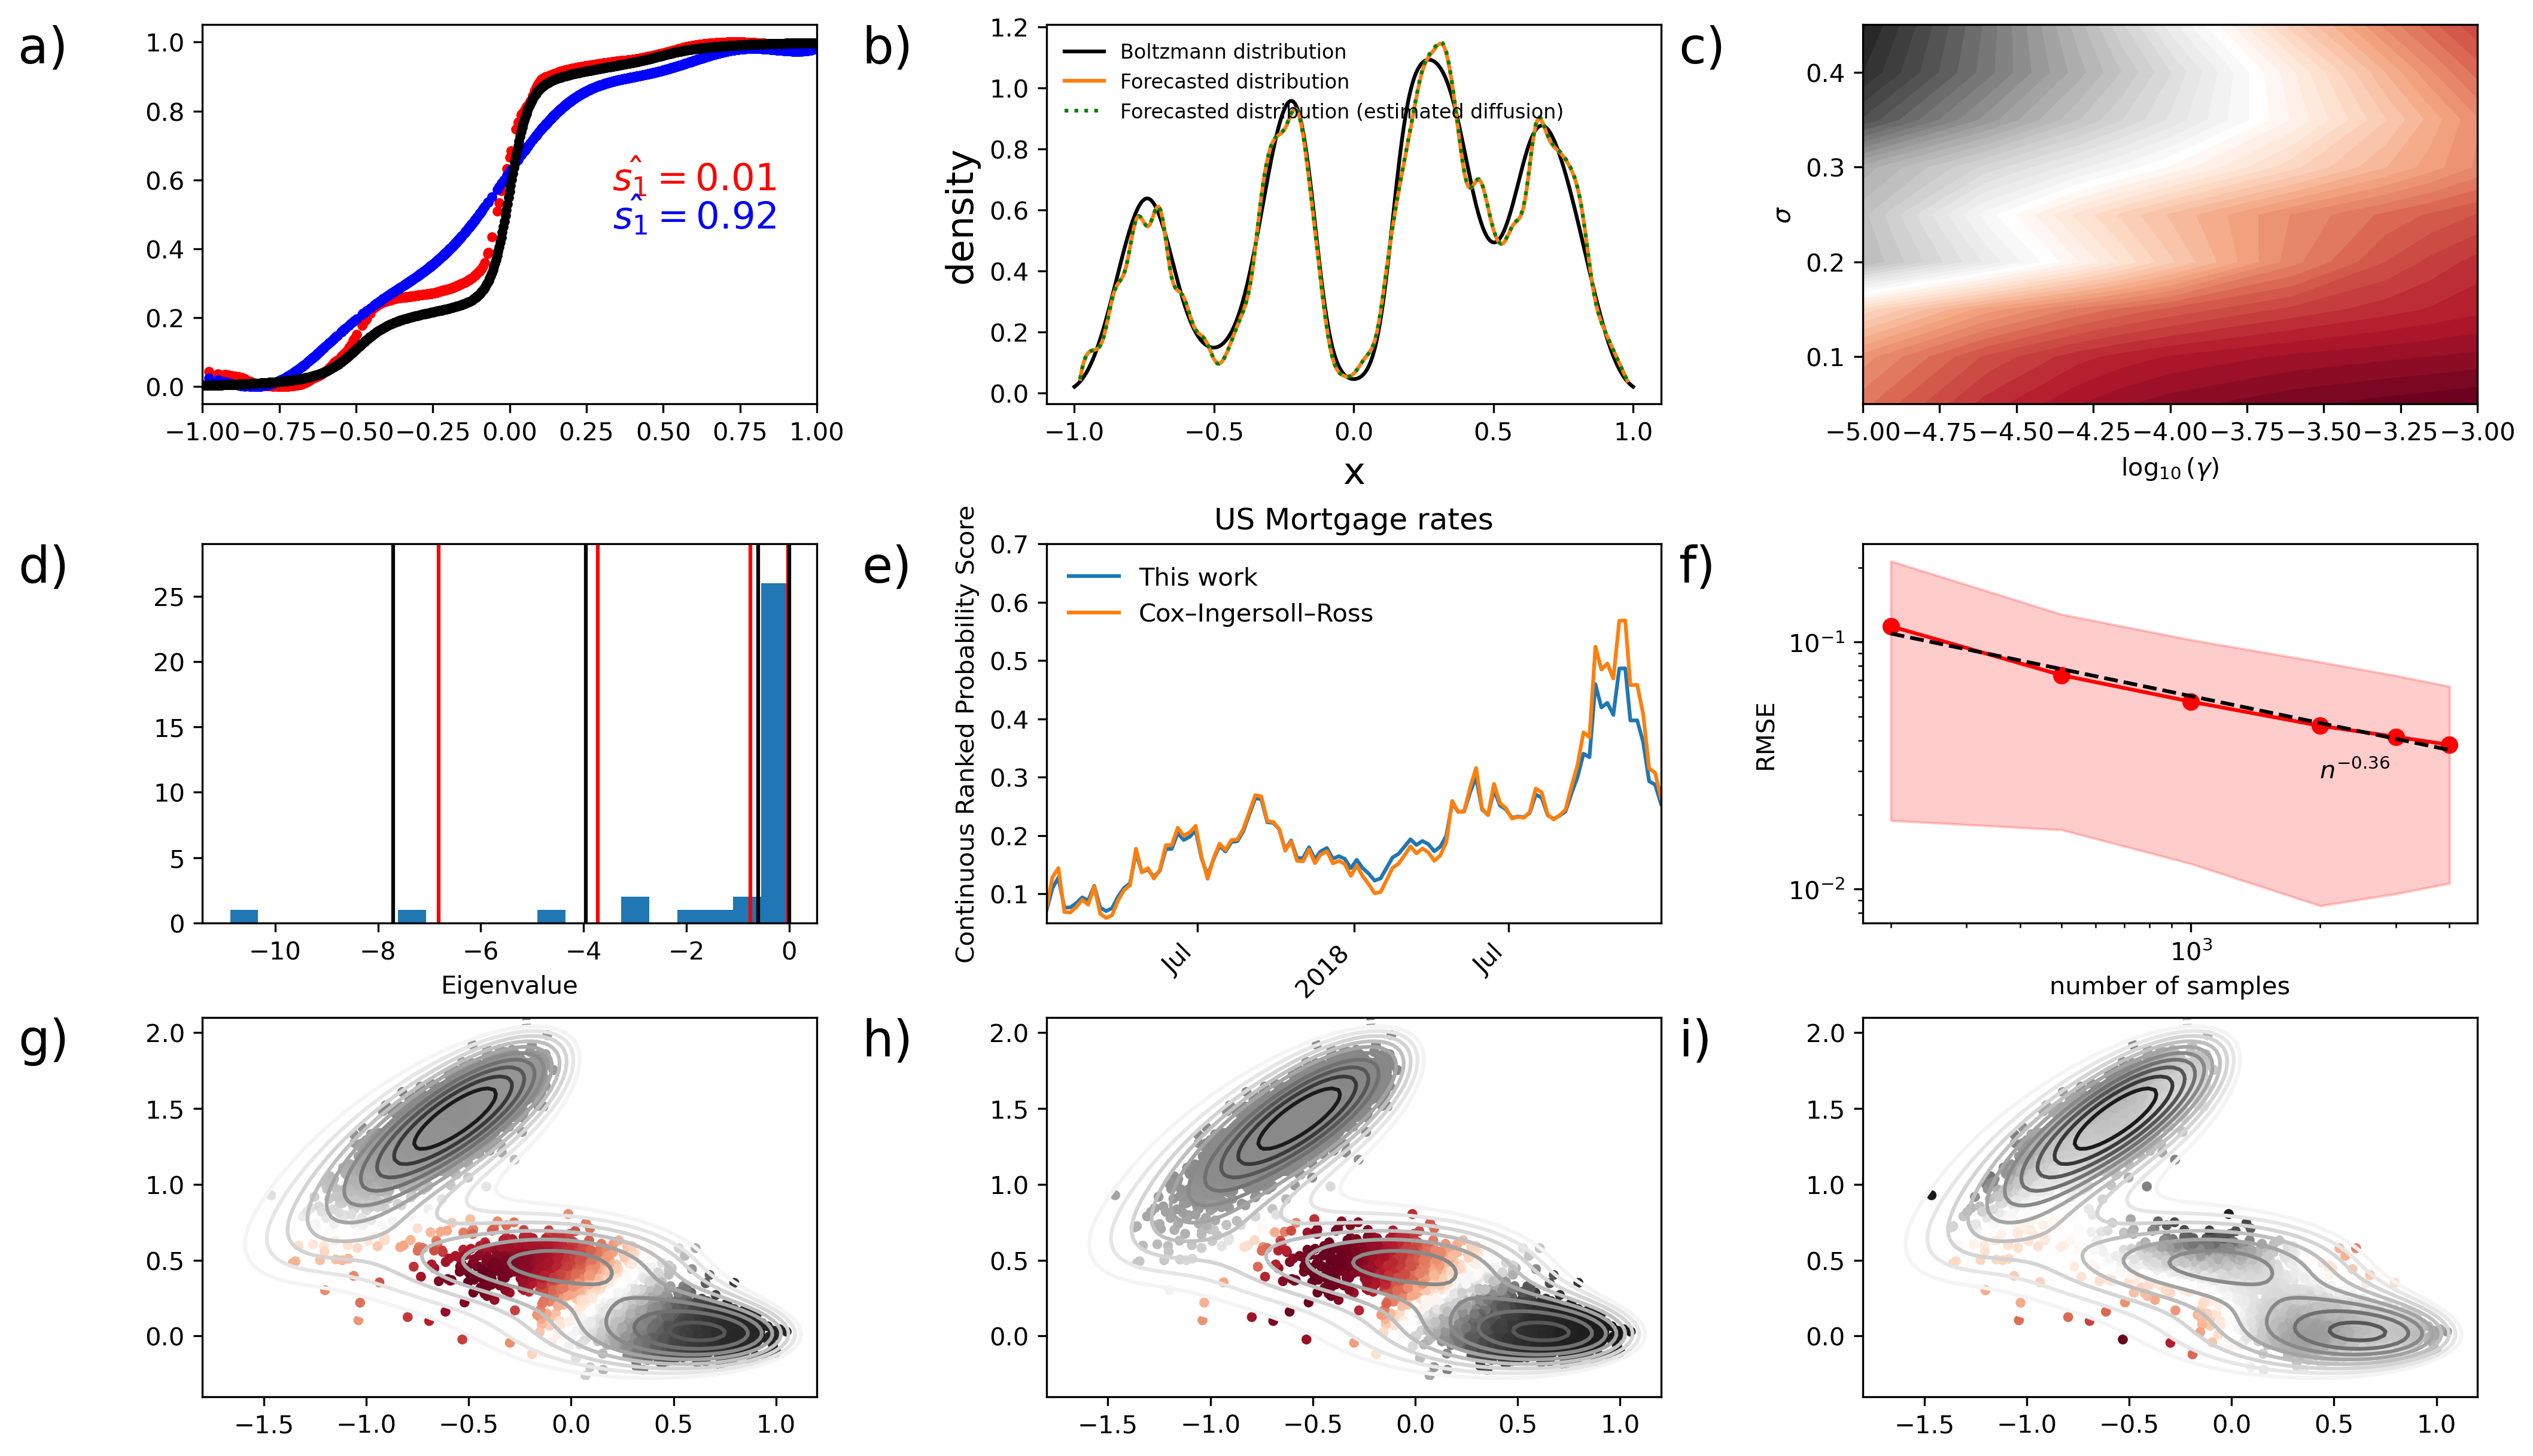

In [86]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(3,3, figsize=(14,8),constrained_layout=True,dpi=300)
def plot_ef(x,y,ef,ax):
    im = ax.scatter(x,y,c=ef,cmap="RdGy",marker=".")
    return im




efuns_4W[:,-2] = (efuns_4W[:,-2]-efuns_4W[:,-2].min())/(efuns_4W[:,-2].max()-efuns_4W[:,2].min())
efuns_4W_2[:,-2] = (efuns_4W_2[:,-2]-efuns_4W_2[:,-2].min())/(efuns_4W_2[:,-2].max()-efuns_4W_2[:,2].min())

solutions[:,1] = (solutions[:,1]-solutions[:,1].min())/(solutions[:,1].max() - solutions[:,1].min())
axs[0,0].scatter(x_axis,efuns_4W[:,-2],c="r",marker=".")
axs[0,0].scatter(x_axis,1-efuns_4W_2[:,-2],c="b",marker=".")
axs[0,0].plot(x_values,solutions[:,1],marker=".",c="k")
axs[0,0].text(0.8, 0.6, r"$\hat{s_1}=0.01$", horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes,c="r", size=15)
axs[0,0].text(0.8, 0.5, r"$\hat{s_1}=0.92$", horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes,c="b",size=15)

axs[0,0].set_xlim(-1,1)
axs[0,0].text(-0.3,0.9,"a)",transform=axs[0,0].transAxes,size=20)
axs[1,0].hist(ev_krr[65:],bins=20)
axs[1,0].vlines(ev_rrr,0,35,colors="r")
axs[1,0].vlines(gt_value,0,35,colors="k")
axs[1,0].set_ylim(0,29)


axs[1,0].text(-0.3,0.9,"d)",transform=axs[1,0].transAxes,size=20)


axs[0,1].plot(bins,((boltzmann)/(boltzmann.sum()*(bins[1]-bins[0]))), "k",label="Boltzmann distribution")
axs[0,1].plot(x_new_k,y_new_k, "tab:orange",label="Forecasted distribution")
axs[0,1].plot(x_new_dd,y_new_dd, "g:",label="Forecasted distribution (estimated diffusion)")
#ax.plot(x_new_s,y_new_s,label="Distribution from data")
#ax.hist(µsample,bins=1000,density=True, histtype="step",label="distribution from data")
legend = axs[0,1].legend(loc='upper left', fontsize=8, frameon = False)
axs[0,1].set_xlabel("x",fontsize=15)
axs[0,1].set_ylabel("density",fontsize=15)
axs[0,1].text(-0.3,0.9,"b)",transform=axs[0,1].transAxes,size=20)

axs[0,2].contourf(np.log10(gamma_v),sigma_v,np.log10(s),levels=50,cmap="RdGy")
axs[0,2].text(-0.3,0.9,"c)",transform=axs[0,2].transAxes,size=20)
axs[0,2].set_xlabel(r"$\log_{10}(\gamma)$")
axs[0,2].set_ylabel(r"$\sigma$")






axs[1,1].plot(df_test,crpss, label="This work")
axs[1,1].plot(df_test,report, label="Cox–Ingersoll–Ross")
#plt.plot(report_dli["CRPS"], label="dli")
axs[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show ticks for each day
axs[1,1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1,1].xaxis.get_major_locator()))
axs[1,1].set_xmargin(0)

for label in axs[1,1].get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
axs[1,1].set_ylim(0.05, 0.7)
axs[1,1].set_title('US Mortgage rates')
axs[1,1].set_ylabel('Continuous Ranked Probability Score')
legend = axs[1,1].legend(loc='upper left',  frameon = False)

axs[1,1].text(-0.3,0.9,"e)",transform=axs[1,1].transAxes,size=20)

n =[200,500,1000,2000,3000,4000]
m,b = np.polyfit(np.log(n),np.log(list_rmse),1)
axs[1,2].plot(n,list_rmse, marker="o",color="r")
axs[1,2].fill_between(n,list_rmse-list_std_rmse/np.sqrt(2),list_rmse+list_std_rmse/np.sqrt(2),alpha=0.2,color="r")
axs[1,2].plot(n,np.exp(b)*np.exp(m*np.log(n)),"--",color="k")
axs[1,2].text(0.8, 0.4, r"$n^{-0.36}$", horizontalalignment='center', verticalalignment='center', transform=axs[1,2].transAxes,c="k")
axs[1,2].text(-0.3,0.9,"f)",transform=axs[1,2].transAxes,size=20)
axs[1,2].set_xlabel("number of samples")
axs[1,2].set_ylabel("RMSE")

plot_ef(test_set[:,0],test_set[:,1],ef_gen[-3,:],ax=axs[2,0])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[2,0])
axs[2,0].text(-0.3,0.9,"g)",transform=axs[2,0].transAxes,size=20)


plot_ef(test_set_to[:,0],test_set_to[:,1],ef_to[:,-3],ax=axs[2,2])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[2,2])
axs[2,1].text(-0.3,0.9,"h)",transform=axs[2,1].transAxes,size=20)


plot_ef(test_set[:,0],test_set[:,1],1-efuns[closest_points,2],ax=axs[2,1])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[2,1])
axs[2,2].text(-0.3,0.9,"i)",transform=axs[2,2].transAxes,size=20)


axs[1,0].set_xlabel("Eigenvalue")

axs[1,2].set_xscale("log")
axs[1,2].set_yscale("log")